In [52]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

# Define learning parameters

In [53]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 100 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [54]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file input already exists.
Error occurred while processing: input.
A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file outputs already exists.
Error occurred while processing: outputs.


In [55]:
x = torch.randn(2,2)
y = torch.randn(2,1)
torch.cat((x, y), dim=1)

tensor([[ 0.8731, -0.9909,  0.8776],
        [ 0.2375, -0.2042,  2.2911]])

# Generator

In [56]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz + 10, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x, label):
        x = torch.cat((F.one_hot(label, 10), x), dim=1)
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [57]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(10, 10)
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input + 10, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x, label):
        x = x.view(-1, 784)
        x = torch.cat((F.one_hot(label, 10), x), dim = 1)
        return self.main(x)

In [58]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=138, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (label_emb): Embedding(10, 10)
  (main): Sequential(
    (0): Linear(in_features=794, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linea

# Tools for training

In [59]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [60]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [61]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [62]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)


In [63]:
# function to create the noise vector
def create_noise(sample_size, nz):
    label = torch.randint(0, 10, size=(sample_size,)).to(device)
    return label, torch.randn(sample_size, nz).to(device)

In [64]:
def create_noise_arraged(sample_size, nz):
    label = np.array([[i]*10 for i in range(10)])
    label = torch.LongTensor(label.flatten()).to(device)
    return label, torch.randn(sample_size, nz).to(device)

In [65]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [66]:
# create the noise vector - fixed to track how GAN is trained.
randlabel, noise = create_noise_arraged(sample_size, nz)

In [67]:
randlabel

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9], device='cuda:0')

118it [00:11, 10.40it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


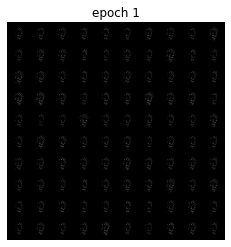

Epoch 1 of 100
Generator loss: 0.92246616, Discriminator loss: 1.21884382


118it [00:11, 10.31it/s]                         


Epoch 2 of 100
Generator loss: 1.69818616, Discriminator loss: 1.00193894


118it [00:11, 10.46it/s]                         


Epoch 3 of 100
Generator loss: 1.33750737, Discriminator loss: 1.02293253


118it [00:11, 10.34it/s]                         


Epoch 4 of 100
Generator loss: 2.12301588, Discriminator loss: 0.65478498


118it [00:11, 10.35it/s]                         


Epoch 5 of 100
Generator loss: 2.90720510, Discriminator loss: 0.51233876


118it [00:11, 10.17it/s]                         


Epoch 6 of 100
Generator loss: 2.68552756, Discriminator loss: 0.60715842


118it [00:11, 10.18it/s]                         


Epoch 7 of 100
Generator loss: 2.77558422, Discriminator loss: 0.46499249


118it [00:11,  9.97it/s]                         


Epoch 8 of 100
Generator loss: 3.36826873, Discriminator loss: 0.30350128


118it [00:11, 10.09it/s]                         


Epoch 9 of 100
Generator loss: 4.13812160, Discriminator loss: 0.43661547


118it [00:11, 10.47it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


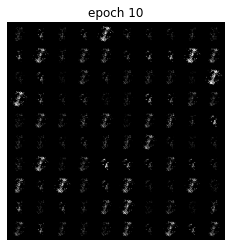

Epoch 10 of 100
Generator loss: 3.53109717, Discriminator loss: 0.42505968


118it [00:12,  9.77it/s]                         


Epoch 11 of 100
Generator loss: 3.55637288, Discriminator loss: 0.48542443


118it [00:11, 10.10it/s]                         


Epoch 12 of 100
Generator loss: 3.02254844, Discriminator loss: 0.52590793


118it [00:11, 10.07it/s]                         


Epoch 13 of 100
Generator loss: 3.41250801, Discriminator loss: 0.40432164


118it [00:11,  9.98it/s]                         


Epoch 14 of 100
Generator loss: 3.86295724, Discriminator loss: 0.32667282


118it [00:11, 10.01it/s]                         


Epoch 15 of 100
Generator loss: 3.77023029, Discriminator loss: 0.35966459


118it [00:11, 10.06it/s]                         


Epoch 16 of 100
Generator loss: 3.29829288, Discriminator loss: 0.52851403


118it [00:11,  9.87it/s]                         


Epoch 17 of 100
Generator loss: 2.84654284, Discriminator loss: 0.53526378


118it [00:11, 10.25it/s]                         


Epoch 18 of 100
Generator loss: 3.23058915, Discriminator loss: 0.46345147


118it [00:11,  9.99it/s]                         


Epoch 19 of 100
Generator loss: 3.31970000, Discriminator loss: 0.37111360


118it [00:11,  9.96it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


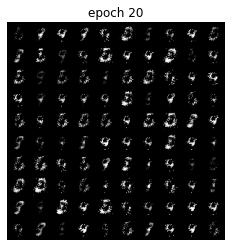

Epoch 20 of 100
Generator loss: 3.60536575, Discriminator loss: 0.46837130


118it [00:11,  9.92it/s]                         


Epoch 21 of 100
Generator loss: 3.19269729, Discriminator loss: 0.46905449


118it [00:12,  9.70it/s]                         


Epoch 22 of 100
Generator loss: 3.41771936, Discriminator loss: 0.45536545


118it [00:11, 10.06it/s]                         


Epoch 23 of 100
Generator loss: 3.27812910, Discriminator loss: 0.47771698


118it [00:12,  9.76it/s]                         


Epoch 24 of 100
Generator loss: 3.03411555, Discriminator loss: 0.48455220


118it [00:11, 10.01it/s]                         


Epoch 25 of 100
Generator loss: 3.20069385, Discriminator loss: 0.43278787


118it [00:11,  9.86it/s]                         


Epoch 26 of 100
Generator loss: 3.48109603, Discriminator loss: 0.44474536


118it [00:12,  9.71it/s]                         


Epoch 27 of 100
Generator loss: 3.14093804, Discriminator loss: 0.50514293


118it [00:11, 10.01it/s]                         


Epoch 28 of 100
Generator loss: 2.93032908, Discriminator loss: 0.49996999


118it [00:12,  9.59it/s]                         


Epoch 29 of 100
Generator loss: 3.25704694, Discriminator loss: 0.45781308


118it [00:11,  9.99it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


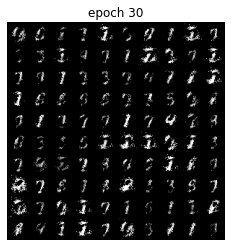

Epoch 30 of 100
Generator loss: 3.40802264, Discriminator loss: 0.40559161


118it [00:11,  9.85it/s]                         


Epoch 31 of 100
Generator loss: 3.27383327, Discriminator loss: 0.47505328


118it [00:12,  9.82it/s]                         


Epoch 32 of 100
Generator loss: 3.36741209, Discriminator loss: 0.43740988


118it [00:11,  9.86it/s]                         


Epoch 33 of 100
Generator loss: 3.13254404, Discriminator loss: 0.47354668


118it [00:12,  9.74it/s]                         


Epoch 34 of 100
Generator loss: 2.83862352, Discriminator loss: 0.55028361


118it [00:11,  9.96it/s]                         


Epoch 35 of 100
Generator loss: 2.99079299, Discriminator loss: 0.50501549


118it [00:12,  9.69it/s]                         


Epoch 36 of 100
Generator loss: 3.30114460, Discriminator loss: 0.48950261


118it [00:12,  9.67it/s]                         


Epoch 37 of 100
Generator loss: 3.18555450, Discriminator loss: 0.48217157


118it [00:12,  9.77it/s]                         


Epoch 38 of 100
Generator loss: 3.28287482, Discriminator loss: 0.45562017


118it [00:12,  9.68it/s]                         


Epoch 39 of 100
Generator loss: 2.92354441, Discriminator loss: 0.52676213


118it [00:12,  9.78it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


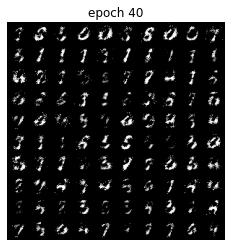

Epoch 40 of 100
Generator loss: 3.15610647, Discriminator loss: 0.51289928


118it [00:12,  9.72it/s]                         


Epoch 41 of 100
Generator loss: 3.00103855, Discriminator loss: 0.54761183


118it [00:12,  9.46it/s]                         


Epoch 42 of 100
Generator loss: 2.64994335, Discriminator loss: 0.61620146


118it [00:12,  9.55it/s]                         


Epoch 43 of 100
Generator loss: 3.05380750, Discriminator loss: 0.48569041


118it [00:12,  9.59it/s]                         


Epoch 44 of 100
Generator loss: 2.72835350, Discriminator loss: 0.56959826


118it [00:12,  9.54it/s]                         


Epoch 45 of 100
Generator loss: 2.96934724, Discriminator loss: 0.50769001


118it [00:12,  9.55it/s]                         


Epoch 46 of 100
Generator loss: 3.21869922, Discriminator loss: 0.53242528


118it [00:11,  9.86it/s]                         


Epoch 47 of 100
Generator loss: 2.86603308, Discriminator loss: 0.57446605


118it [00:12,  9.63it/s]                         


Epoch 48 of 100
Generator loss: 2.67151523, Discriminator loss: 0.64450788


118it [00:12,  9.75it/s]                         


Epoch 49 of 100
Generator loss: 2.62492108, Discriminator loss: 0.63098812


118it [00:11,  9.84it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


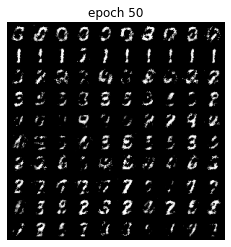

Epoch 50 of 100
Generator loss: 2.63819909, Discriminator loss: 0.61230302


118it [00:12,  9.41it/s]                         


Epoch 51 of 100
Generator loss: 2.69276738, Discriminator loss: 0.57076430


118it [00:11,  9.88it/s]                         


Epoch 52 of 100
Generator loss: 2.72007751, Discriminator loss: 0.57099521


118it [00:12,  9.42it/s]                         


Epoch 53 of 100
Generator loss: 2.71880841, Discriminator loss: 0.59183174


118it [00:12,  9.79it/s]                         


Epoch 54 of 100
Generator loss: 2.60470510, Discriminator loss: 0.67880708


118it [00:12,  9.42it/s]                         


Epoch 55 of 100
Generator loss: 2.47686744, Discriminator loss: 0.69383001


118it [00:11,  9.85it/s]                         


Epoch 56 of 100
Generator loss: 2.47782135, Discriminator loss: 0.63562542


118it [00:12,  9.54it/s]                         


Epoch 57 of 100
Generator loss: 2.53045368, Discriminator loss: 0.61275589


118it [00:12,  9.76it/s]                         


Epoch 58 of 100
Generator loss: 2.45843649, Discriminator loss: 0.67040539


118it [00:12,  9.49it/s]                         


Epoch 59 of 100
Generator loss: 2.40857315, Discriminator loss: 0.67852664


118it [00:12,  9.73it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


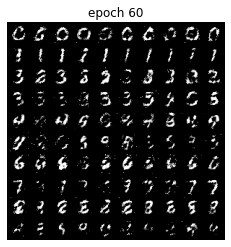

Epoch 60 of 100
Generator loss: 2.52248526, Discriminator loss: 0.61694783


118it [00:12,  9.42it/s]                         


Epoch 61 of 100
Generator loss: 2.66639447, Discriminator loss: 0.60453349


118it [00:12,  9.44it/s]                         


Epoch 62 of 100
Generator loss: 2.40462279, Discriminator loss: 0.68144721


118it [00:12,  9.55it/s]                         


Epoch 63 of 100
Generator loss: 2.38151622, Discriminator loss: 0.66865969


118it [00:12,  9.63it/s]                         


Epoch 64 of 100
Generator loss: 2.39431596, Discriminator loss: 0.67802614


118it [00:12,  9.39it/s]                         


Epoch 65 of 100
Generator loss: 2.41320014, Discriminator loss: 0.66445476


118it [00:12,  9.66it/s]                         


Epoch 66 of 100
Generator loss: 2.49288964, Discriminator loss: 0.68239212


118it [00:12,  9.56it/s]                         


Epoch 67 of 100
Generator loss: 2.38592982, Discriminator loss: 0.67876315


118it [00:12,  9.43it/s]                         


Epoch 68 of 100
Generator loss: 2.32881260, Discriminator loss: 0.71364874


118it [00:12,  9.23it/s]                         


Epoch 69 of 100
Generator loss: 2.22027302, Discriminator loss: 0.72352886


118it [00:12,  9.61it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


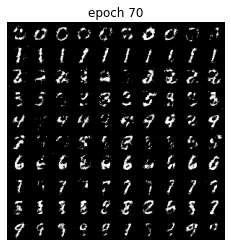

Epoch 70 of 100
Generator loss: 2.20826197, Discriminator loss: 0.74102950


118it [00:12,  9.41it/s]                         


Epoch 71 of 100
Generator loss: 2.23507023, Discriminator loss: 0.71678883


118it [00:12,  9.52it/s]                         


Epoch 72 of 100
Generator loss: 2.13700366, Discriminator loss: 0.74709564


118it [00:12,  9.39it/s]                         


Epoch 73 of 100
Generator loss: 2.21170831, Discriminator loss: 0.73470312


118it [00:12,  9.54it/s]                         


Epoch 74 of 100
Generator loss: 2.19633126, Discriminator loss: 0.76601511


118it [00:12,  9.47it/s]                         


Epoch 75 of 100
Generator loss: 2.10586977, Discriminator loss: 0.76522070


118it [00:12,  9.26it/s]                         


Epoch 76 of 100
Generator loss: 2.14375401, Discriminator loss: 0.74787521


118it [00:12,  9.57it/s]                         


Epoch 77 of 100
Generator loss: 2.14786768, Discriminator loss: 0.75403130


118it [00:12,  9.27it/s]                         


Epoch 78 of 100
Generator loss: 1.99748230, Discriminator loss: 0.79196912


118it [00:12,  9.44it/s]                         


Epoch 79 of 100
Generator loss: 1.96356952, Discriminator loss: 0.80713767


118it [00:12,  9.48it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


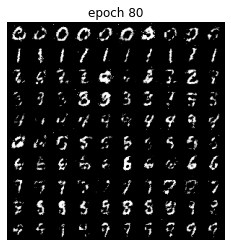

Epoch 80 of 100
Generator loss: 2.00788665, Discriminator loss: 0.79765433


118it [00:12,  9.37it/s]                         


Epoch 81 of 100
Generator loss: 1.95098591, Discriminator loss: 0.81568527


118it [00:12,  9.40it/s]                         


Epoch 82 of 100
Generator loss: 1.83433747, Discriminator loss: 0.86307043


118it [00:12,  9.20it/s]                         


Epoch 83 of 100
Generator loss: 1.81031513, Discriminator loss: 0.83953929


118it [00:12,  9.48it/s]                         


Epoch 84 of 100
Generator loss: 1.88083494, Discriminator loss: 0.83746344


118it [00:12,  9.36it/s]                         


Epoch 85 of 100
Generator loss: 2.00063276, Discriminator loss: 0.83735979


118it [00:12,  9.50it/s]                         


Epoch 86 of 100
Generator loss: 1.95439661, Discriminator loss: 0.83790416


118it [00:12,  9.30it/s]                         


Epoch 87 of 100
Generator loss: 1.84542012, Discriminator loss: 0.83830339


118it [00:12,  9.32it/s]                         


Epoch 88 of 100
Generator loss: 1.84480608, Discriminator loss: 0.85595644


118it [00:12,  9.46it/s]                         


Epoch 89 of 100
Generator loss: 1.87565207, Discriminator loss: 0.84134567


118it [00:12,  9.31it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


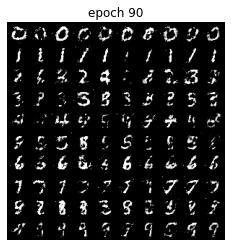

Epoch 90 of 100
Generator loss: 1.86991262, Discriminator loss: 0.84252679


118it [00:12,  9.51it/s]                         


Epoch 91 of 100
Generator loss: 1.90707123, Discriminator loss: 0.82381278


118it [00:12,  9.33it/s]                         


Epoch 92 of 100
Generator loss: 1.79395139, Discriminator loss: 0.88863981


118it [00:13,  9.05it/s]                         


Epoch 93 of 100
Generator loss: 1.79513752, Discriminator loss: 0.86661273


118it [00:12,  9.34it/s]                         


Epoch 94 of 100
Generator loss: 1.85672510, Discriminator loss: 0.85377204


118it [00:12,  9.24it/s]                         


Epoch 95 of 100
Generator loss: 1.74897301, Discriminator loss: 0.88519436


118it [00:12,  9.34it/s]                         


Epoch 96 of 100
Generator loss: 1.84622991, Discriminator loss: 0.84702951


118it [00:12,  9.16it/s]                         


Epoch 97 of 100
Generator loss: 1.76151645, Discriminator loss: 0.87622380


118it [00:12,  9.25it/s]                         


Epoch 98 of 100
Generator loss: 1.79827344, Discriminator loss: 0.86768931


118it [00:12,  9.39it/s]                         


Epoch 99 of 100
Generator loss: 1.74380541, Discriminator loss: 0.87907392


118it [00:12,  9.12it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


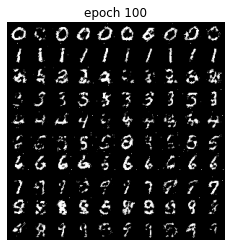

Epoch 100 of 100
Generator loss: 1.75156355, Discriminator loss: 0.87456965


In [69]:
torch.manual_seed(7777)

def generator_loss(output, true_label):
    ############ YOUR CODE HERE ##########
    return criterion(output, true_label)
    
    
    ######################################
    
def discriminator_loss(output_real, true_label_real, output_fake, true_label_fake):
    ############ YOUR CODE HERE ##########
    
    return criterion(output_real, true_label_real) + criterion(output_fake, true_label_fake)
    
    
    ######################################
    

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        ############ YOUR CODE HERE ########## 
        noise_sigma = 0.1
        now_bs = data[0].shape[0]
        randlabel_train, train_noise = create_noise(now_bs, nz)
        optim_d.zero_grad()
        optim_g.zero_grad()
        generated_img = generator(train_noise,randlabel_train)
        generated_img = generated_img + noise_sigma*torch.randn_like(generated_img).to(device)
        real_img = data[0].to(device)
        real_img = real_img + noise_sigma*torch.randn_like(real_img).to(device)
        real_label = data[1].to(device)
        output_real = discriminator(real_img, real_label)
        output_fake = discriminator(generated_img, randlabel_train)
        # print(output_real)
        loss_d_ep = discriminator_loss(output_real, label_real(now_bs), output_fake, label_fake(now_bs)) #taking negative to maximize the loss
        # print(loss_d_ep)
        loss_d_ep.backward()
        loss_d = loss_d + loss_d_ep
        optim_d.step()

        optim_d.zero_grad()
        optim_g.zero_grad()
        randlabel_train, train_noise = create_noise(now_bs, nz)
        generated_img = generator(train_noise, randlabel_train)
        generated_img = generated_img + noise_sigma*torch.randn_like(generated_img).to(device)
        output_fake = discriminator(generated_img, randlabel_train)
        loss_g_ep = generator_loss(output_fake, label_real(now_bs))
        loss_g = loss_g + loss_g_ep
        loss_g_ep.backward()
        optim_g.step()
        ######################################
    
    
    # create the final fake image for the epoch
    generated_img = generator(noise, randlabel).cpu().detach()
    
    # make the images as grid
    generated_img = make_grid(generated_img, nrow=10)
    
    # visualize generated images
    if (epoch + 1) % 10 == 0 or epoch == 0 :
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()
    
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

# Q. Write training loop

In [70]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [71]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

In [72]:
for i in range(len(losses_g)):
    losses_g[i] = losses_g[i].cpu().detach().numpy()
    losses_d[i] = losses_d[i].cpu().detach().numpy()

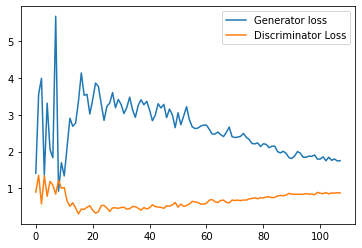

In [73]:
# plot and save the generator and discriminator loss
plt.figure()

plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.pdf')

In [75]:
losses_g

[array(1.4094617, dtype=float32),
 array(3.5596454, dtype=float32),
 array(3.9921358, dtype=float32),
 array(1.357172, dtype=float32),
 array(3.3165066, dtype=float32),
 array(2.0541868, dtype=float32),
 array(1.8338324, dtype=float32),
 array(5.680751, dtype=float32),
 array(0.92246616, dtype=float32),
 array(1.6981862, dtype=float32),
 array(1.3375074, dtype=float32),
 array(2.1230159, dtype=float32),
 array(2.907205, dtype=float32),
 array(2.6855276, dtype=float32),
 array(2.7755842, dtype=float32),
 array(3.3682687, dtype=float32),
 array(4.1381216, dtype=float32),
 array(3.5310972, dtype=float32),
 array(3.556373, dtype=float32),
 array(3.0225484, dtype=float32),
 array(3.412508, dtype=float32),
 array(3.8629572, dtype=float32),
 array(3.7702303, dtype=float32),
 array(3.2982929, dtype=float32),
 array(2.8465428, dtype=float32),
 array(3.2305892, dtype=float32),
 array(3.3197, dtype=float32),
 array(3.6053658, dtype=float32),
 array(3.1926973, dtype=float32),
 array(3.4177194, dty

In [5]:
0.1*0.2*(0.1*0.9*0.7 + 0.9*0.2*0.1)


0.0016200000000000003

In [6]:
0.01016/(0.01016+0.00162)

0.8624787775891342

In [8]:
0.00162*4


0.00648

In [9]:
0.1*0.2*(0.9*0.9*0.7 + 0.1*0.2*0.1)

0.011380000000000001

In [10]:
0.1*0.2*(0.3*0.9*0.7 + 0.7*0.2*0.1) 

0.004060000000000001

In [11]:
0.01138/(0.004066+ 0.01138)

0.7367603262980706

In [12]:
import math
def log(x):
    return math.log2(x)

In [13]:
(-2*0.5*log(0.5)) - (0.4*(-0.1*log(0.1)-0.9*log(0.9))+0.6*(-0.167*log(0.167)-0.833*log(0.833)))

0.42192427001863597

In [14]:
(-2*0.5*log(0.5)) - (0.55*(-0.691*log(0.691)-0.309*log(0.309))+0.45*(-0.267*log(0.267)-0.733*log(0.733)))

0.13268427004101646

In [15]:
(-0.45*log(0.45)-0.55*log(0.55)) - (0.5*(-0.9*log(0.9)-0.1*log(0.1))+0.5*(-0.8*log(0.8)-0.2*log(0.2))) 

0.3973126097494867